In [1]:
!where python

c:\Users\HK-Laptop-V639\Documents\GitHub\696\env696\Scripts\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Programs\Python\Python312\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
# run this code to make sure you install all the required libraries
# be sure you are in virtual environment before install, otherwise it will overwrite your local environment

# !pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np

In [4]:
pd.set_option("display.max_columns", None)
RANDOM_SEED = 123

In [22]:
# import necessary assets
import joblib

# train df
train = joblib.load('assets/train.joblib')

# tfidf_matrix
title_en_tfidf_matrix = joblib.load('assets/title_en_tfidf_matrix.joblib')
synopsis_tfidf_matrix = joblib.load('assets/synopsis_tfidf_matrix.joblib')

# tfidf vectorizer
tfidf_title = joblib.load('assets/tfidf_title_vectorizer.joblib')
tfidf_synopsis = joblib.load('assets/tfidf_synopsis_vectorizer.joblib')

# skipgram
skipgram_model_title = joblib.load('assets/skipgram_model_title.joblib')
skipgram_model_synopsis = joblib.load('assets/skipgram_model_synopsis.joblib')

# Topic modeling

In [6]:
NUM_OF_TOPIC = 8

## LDA

In [7]:
# combine tfidf title and synopsis together as input of topic modeling
from scipy.sparse import hstack

combined_tfidf_matrix = hstack([title_en_tfidf_matrix, synopsis_tfidf_matrix])

# Combine the feature names from both vectorizers
feature_names_title = tfidf_title.get_feature_names_out().tolist()
feature_names_synopsis = tfidf_synopsis.get_feature_names_out().tolist()
combined_feature_names = feature_names_title + feature_names_synopsis

# mimic the behavior of a single vectorizer for pyLDAvis visualization
class CombinedVectorizer:
    def get_feature_names_out(self):
        return combined_feature_names

In [8]:
# LDA with tfidf title and synopsis
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPIC, random_state=RANDOM_SEED)
lda_topic_distribution = lda_model.fit_transform(combined_tfidf_matrix)

temp_df = pd.DataFrame(lda_topic_distribution)

# the dominant topic for each document
train['topic_LDA'] = temp_df.idxmax(axis=1)
# the confidence score for each document
train['topic_LDA_score'] = temp_df.max(axis=1)
# normalize the confidence scores to range between 0 and 1
train['topic_LDA_score'] = (train['topic_LDA_score'] - train['topic_LDA_score'].min()) / (train['topic_LDA_score'].max() - train['topic_LDA_score'].min())

# visualization
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(lda_model, combined_tfidf_matrix, CombinedVectorizer(), mds='tsne')
lda_vis

PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
2      -30.529730  80.021797       1        1  23.387092
1       89.042908 -46.920479       2        1  19.614985
3       24.182608 -23.289671       3        1  17.928312
0      102.389328  24.702610       4        1  12.908780
6      -89.539879 -59.093845       5        1  11.159025
7      -31.245966  33.185181       6        1   7.684740
5      -39.773121 -23.422989       7        1   4.064944
4       38.219860  41.940674       8        1   3.252122, topic_info=               Term         Freq        Total Category  logprob  loglift
5387            org  2291.000000  2291.000000  Default  30.0000  30.0000
5631         person  2302.000000  2302.000000  Default  29.0000  29.0000
9936  person person  1365.000000  1365.000000  Default  28.0000  28.0000
9870         person  2734.000000  2734.000000  Default  27.0000  27.0000
9803            org  1880.000000  1880.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
9654            man    12.582893   287.661209   Topic8  -5.7426   0.2964
9803            org    14.814831  1880.990249   Topic8  -5.5793  -1.4181
9475           idol     8.600744    63.203231   Topic8  -6.1231   1.4314
9366            gpe     9.257850   941.138055   Topic8  -6.0495  -1.1958
9590           life     8.782879   408.463112   Topic8  -6.1021  -0.4137

[590 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
88         4  0.815514    actually
8673       1  0.033346  adaptation
8673       2  0.166732  adaptation
8673       3  0.033346  adaptation
8673       6  0.766967  adaptation
...      ...       ...         ...
10644      5  0.125884       young
10644      6  0.003934       young
10644      7  0.015736       young
10644      8  0.019669       young
8641       2  0.902017      zombie

[1374 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 7, 8, 6, 5])

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topic_score_distribution(train, topic_col, score_col, title):
    """
    Function to visualize the distribution of the confidence score for each topic.
    """

    plt.figure(figsize=(10, 8))

    sns.boxplot(x=topic_col, y=score_col, data=train)

    plt.title(f'Distribution of Topic Scores for {title}')
    plt.xlabel('Topic')
    plt.ylabel('Normalized Topic Score')
    plt.xticks(range(NUM_OF_TOPIC), [i for i in range(NUM_OF_TOPIC)])
    
    plt.show()

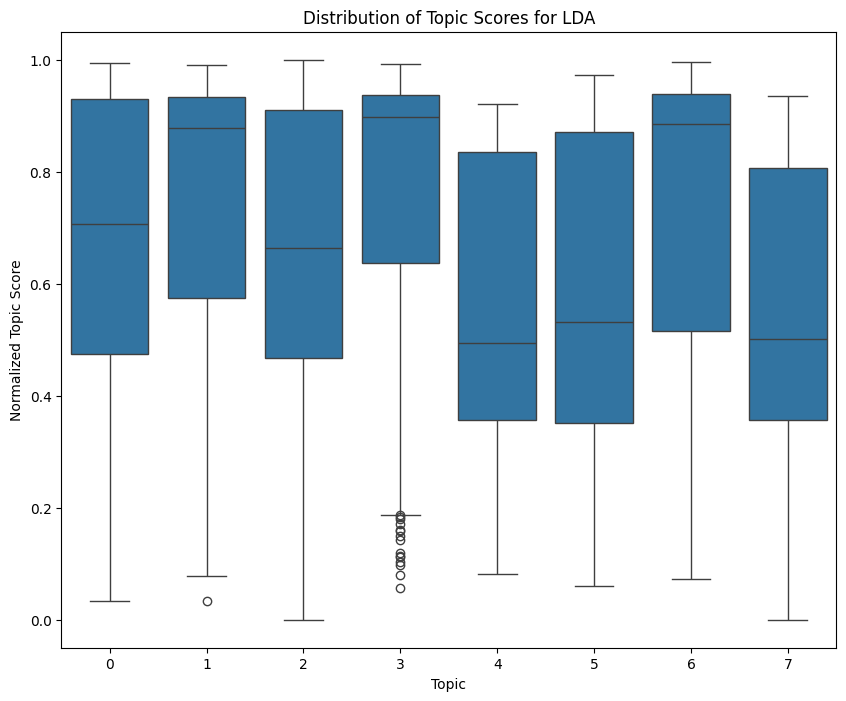

In [10]:
plot_topic_score_distribution(train, 'topic_LDA', 'topic_LDA_score', 'LDA')

In [11]:
# top 20 confidence for each topic
for topic in range(NUM_OF_TOPIC):
    print('topic: ', topic, '\n', train[train['topic_LDA']==topic].sort_values('topic_LDA_score', ascending=False)['title_japanese'].head(20).tolist())

topic:  0 
 ['我在仙界挣积分', 'らんま１／２\u3000熱闘歌合戦', 'ろりこんにちは！', '디펜스 게임의 폭군이 되었다', 'ハイスクールD×D BorN', '熊出没之探险日记', '너의 미소가 함정', 'デザートイーグル', '憎らしいほど愛してる', '地球少女アルジュナ', '全职高手', 'キッズキャッスル', '黒の召喚士', 'ロンリーとオーガンジー', '大自然の魔獣 バギ', '家庭教師ヒットマンREBORN! ボンゴレファミリー総登場! ボンゴレ式修学旅行、来る!!', '子連れ狼', 'アンネの日記', 'いいなりのすゝめ', '劇場版 美少女戦士セーラームーンEternal']
topic:  1 
 ['3月のライオン', 'アンドロイドは経験人数に入りますか??', 'きらりん☆レボリューション', 'セラピーゲーム リスタート', 'ナンジャモの相棒は何者なんじゃ!?【ドンナモンジャTV】', 'ましまえん', '自動販売機に生まれ変わった俺は迷宮を彷徨う', 'うずまき', 'いないいないばあば', 'キャップ革命ボトルマン', '움직임의 사전', '姫騎士がクラスメート!', 'わたしのトーチカ', '女生徒', 'ガートルードのレシピ', '栄光のナポレオン - エロイカ', '強制ハーレム契約', '島耕作のアジア立志伝', '恐怖・地獄少女', 'ふしぎの国の有栖川さん']
topic:  2 
 ['トップをねらえ！ GunBuster', '남자주인공의 여자사람친구입니다', '異世界はスマートフォンとともに。', 'へび少女', '킹더랜드', '絶対にときめいてはいけない!', 'スローループ', 'ELDEN RING 黄金樹への道', 'ワンピース\u3000フィルム\u3000\ufeffＺ', 'テラストーリー', 'ワンピース ねじまき島の冒険', 'スキップとローファー', '僕だけのロマンチスト', '青の世界', 'On the Way to a Smile ファイナルファンタジーVII', '聖女二人の異世界ぶらり旅', '絶対衝激～プラトニックハート～', '白魔導師シロップさん', '宇宙ショーへようこそ', 'ピーチガールNEXT']
topic:  3 
 

## NMF

In combining the title and synopsis embeddings for each anime/manga entry, we faced the challenge of differing word lengths. Directly stacking the embeddings could cause imbalance in representing the two sources of information. To address this, we chose to average the embeddings for each entry, allowing us to capture the overall semantic meaning of the entire document without losing the key contextual information. While it does lose some individual word-level granularity, the averaged vector still provides a strong representation of the dominant themes.

In [12]:
train['title_en_skipgram'][0].shape

(4, 300)

In [13]:
train['synopsis_skipgram'][0].shape

(108, 150)

In [14]:
# combine skip-gram title and synopsis together as input of topic modeling

train['combined_embedding'] = train.apply(
    lambda row: np.hstack((
        np.mean(row['title_en_skipgram'], axis=0),
        np.mean(row['synopsis_skipgram'], axis=0)
    ))
    , axis=1
)
train['combined_embedding'][0].shape

(450,)

In [15]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

# convert the series into a 2D numpy array
embedding_matrix = np.vstack(train['combined_embedding'].values)

# apply Min-Max Normalization to due with negative value
min_max_scaler = MinMaxScaler()
embedding_matrix_non_negative = min_max_scaler.fit_transform(embedding_matrix)

nmf_model = NMF(n_components=NUM_OF_TOPIC, random_state=RANDOM_SEED, init="nndsvd", max_iter=20000)
nmf_topic_distribution = nmf_model.fit_transform(embedding_matrix_non_negative)

# find the dominant topic for each document
train['topic_nmf'] = np.argmax(nmf_topic_distribution, axis=1)
# the confidence score for each document
train['topic_nmf_score'] = np.max(nmf_topic_distribution, axis=1)
# normalize the confidence scores to range between 0 and 1
train['topic_nmf_score'] = (train['topic_nmf_score'] - train['topic_nmf_score'].min()) / (train['topic_nmf_score'].max() - train['topic_nmf_score'].min())

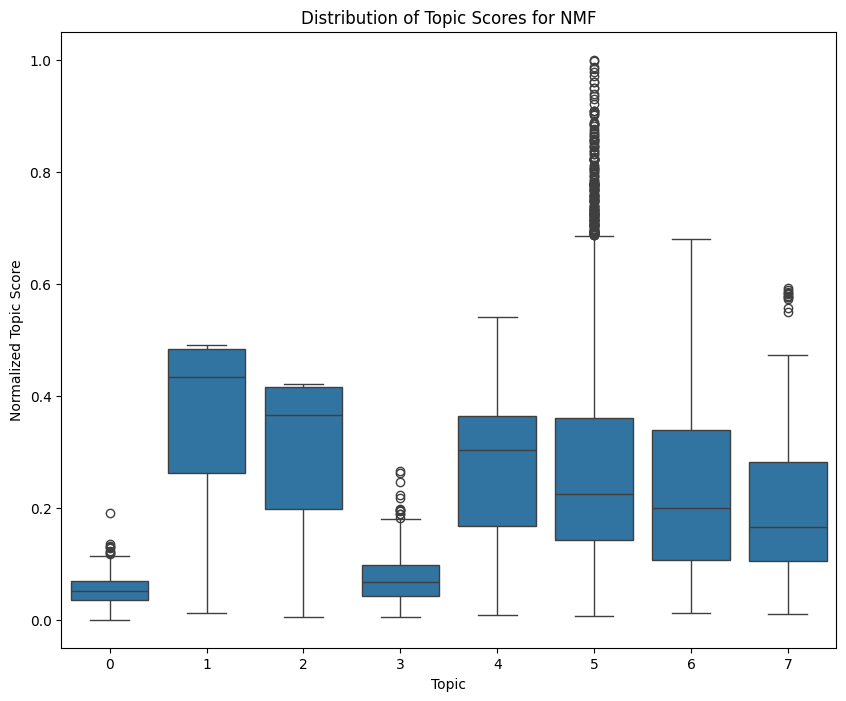

In [16]:
plot_topic_score_distribution(train, 'topic_nmf', 'topic_nmf_score', 'NMF')

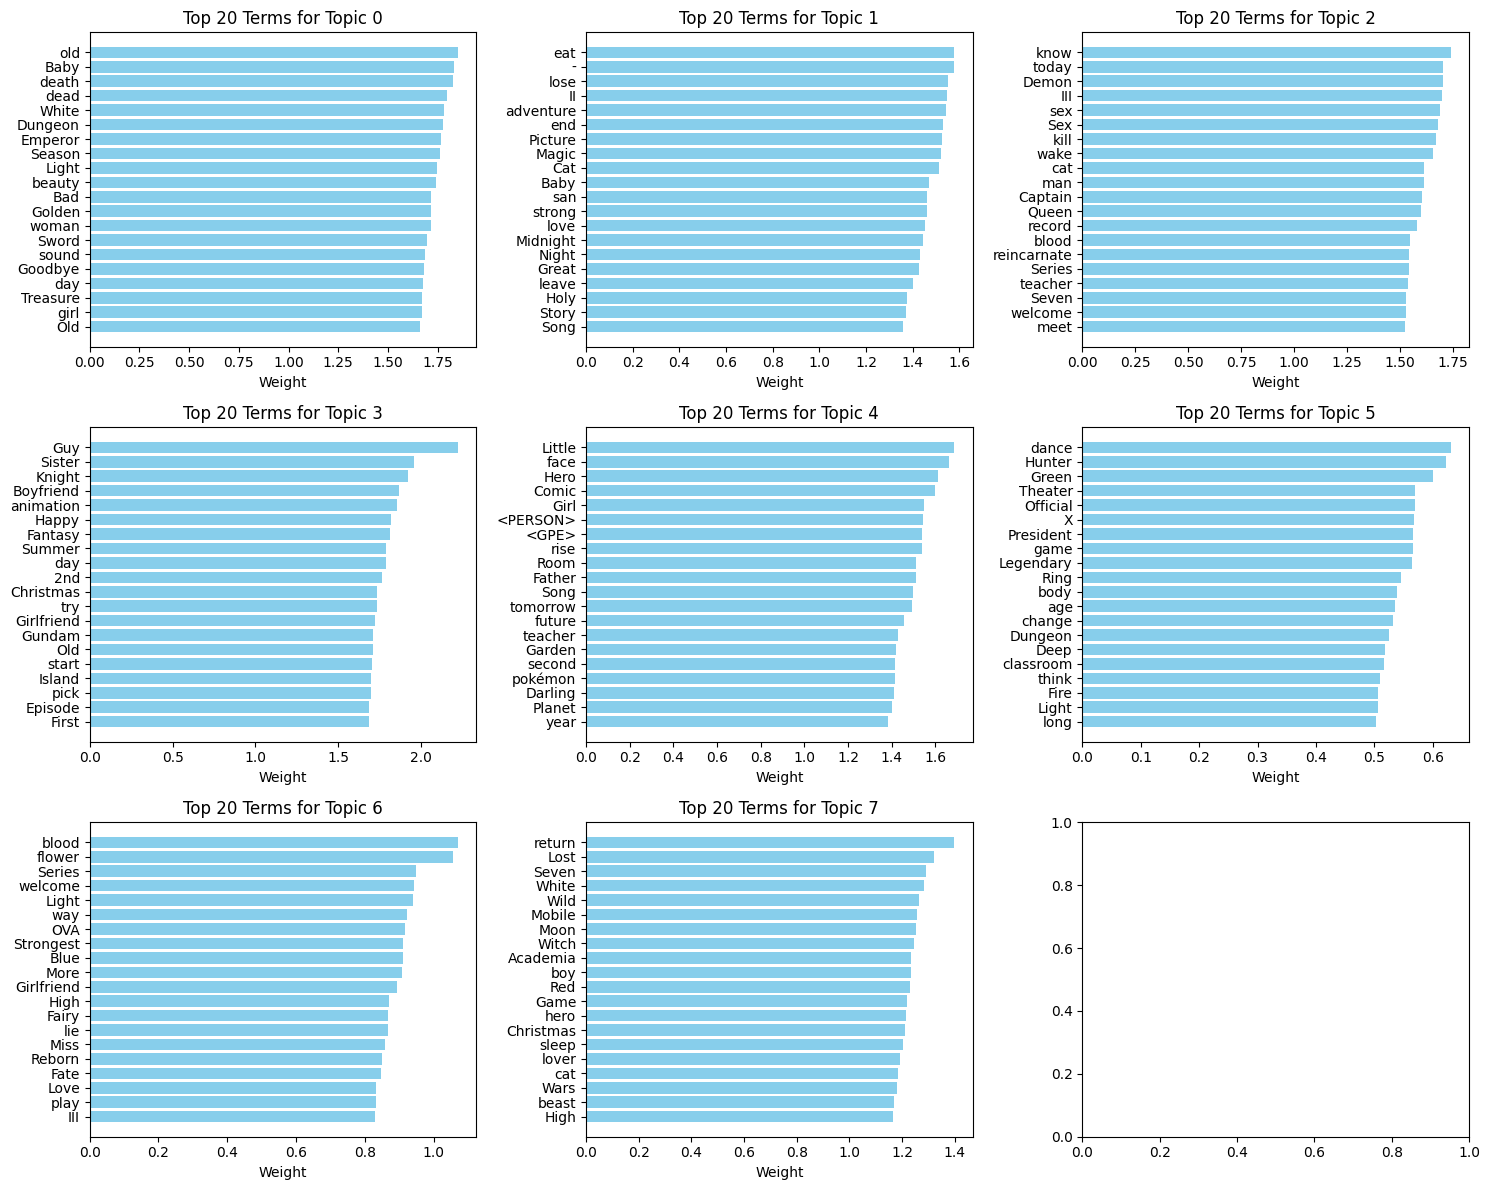

In [34]:
# review top terms for each topic
import matplotlib.pyplot as plt

topic_term_matrix = nmf_model.components_
combined_vocab = list(skipgram_model_title.wv.index_to_key) + list(skipgram_model_synopsis.wv.index_to_key)

def plot_top_terms_per_topic(components, feature_names, top_n=20, columns=3):
    num_topics = components.shape[0]
    rows = (num_topics + columns - 1) // columns  # calculate number of rows needed
    
    fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 4))
    axes = axes.flatten()
    
    # loop through each topic and plot the top terms
    for topic_idx, topic in enumerate(components):
        top_term_indices = topic.argsort()[-top_n:][::-1]
        top_terms = [feature_names[i] for i in top_term_indices]
        top_term_weights = topic[top_term_indices]
        
        ax = axes[topic_idx] if num_topics > 1 else axes
        ax.barh(top_terms, top_term_weights, color="skyblue")
        ax.set_title(f"Top {top_n} Terms for Topic {topic_idx}")
        ax.invert_yaxis()  # Invert to have the highest weight at the top
        ax.set_xlabel("Weight")
    
    plt.tight_layout()
    plt.show()

# Call the function to generate the graph
plot_top_terms_per_topic(topic_term_matrix, combined_vocab)

In [17]:
# top 20 confidence for each topic
for topic in range(NUM_OF_TOPIC):
    print('topic: ', topic, '\n', train[train['topic_nmf']==topic].sort_values('topic_nmf_score', ascending=False)['title_japanese'].head(20).tolist())

topic:  0 
 ['村人ですが何か？', '百妖谱', '인간의 숲', '自分サイズでいこう 私なりのボディポジティブ', '真昼に踊る犯罪者', 'すこやかな歪み', 'ハッピーバースデー 命かがやく瞬間', '你要热烈地亲亲爹', 'エンブリヲン・ロード たねのみち', 'いぬやしき', '俺に注がせてください。～奥手サキュバスとごちそう美青年', '朝からずっしり・ミルクポット', '天眼传奇', '沙流羅 -The Legend of Mother Sarah-', '蟹眼', '识途', '甲鉄城のカバネリ', 'マザールール', '毒ヘビさんにご注意を', '리버사이드']
topic:  1 
 ['キュウマ!', '怪人開発部の黒井津さん', 'ももんがぁモン', '超変身コス∞プレイヤー', 'ふらいんぐうぃっち', 'FAIRY TAIL', 'らせつの花', '星方武侠アウトロースター', '強殖装甲ガイバー', 'ナジカ電撃作戦', 'SOTUS', 'タテの国', 'キャットブルー：ダイナマイト', 'BLACK TORCH', '剣勇伝説ＹＡＩＢＡ', '무림수사대', '万能文化猫娘ＤＡＳＨ！', 'ナジカ電撃作戦', 'E.T.O. [イーティーオー]', 'FAIRY TAIL（フェアリーテイル）']
topic:  2 
 ['聖獣伝 ツインドールズ', 'いぬかみっ!', 'スケルトンダブル', 'ななこSOS', 'ジャングルDEいこう!', '陸上防衛隊まおちゃん', '엔젤 버디', 'ARCANA (アルカナ)', '百千さん家のあやかし王子', 'STRAY LITTLE DEVIL', 'キリングバイツ', 'ZONE-00', '終物語', 'いなり、こんこん、恋いろは。', 'マナリアフレンズ', '黒神 The Animation', 'ドラゴンドライブ', 'アイリスzero', '灰者', '化物語']
topic:  3 
 ['世界か彼女か選べない', '사랑받는 언니가 사라진 세계', 'きみのために世界はある', '女生徒', 'THE GOD OF HIGH SCHOOL ゴッド・オブ・ハイスクール', '女の子ときどき男のこ', 'ハイスクールD×D', 'ハイスクールD×D', '

## BERTopic

As BERTopic can work directly on plain text, we will use the original title and synopsis as input, with minimal pre-processing, like stop word removal and NER, since anime/manga title and synopsis contain large number of named entities.

In [87]:
import spacy

nlp = spacy.load('en_core_web_sm')

def replace_named_entities(doc):
    tokens = []

    for token in doc:
        if not token.ent_type_ in ['PERSON', 'ORG', 'GPE']:
            # remove person, organization, and location entities
            tokens.append(token.text)

    return ' '.join(tokens)

train['title_en_clean'] = [
    replace_named_entities(doc) for doc in nlp.pipe(train['title_english'], batch_size=100, n_process=-1)
]
train['synopsis_clean'] = [
    replace_named_entities(doc) for doc in nlp.pipe(train['synopsis'], batch_size=100, n_process=-1)
]

We will combine title and synopsis together for BERTopic, as this allows the model to capture a broader semantic representation of each document.

In [88]:
train['title_synopsis'] = train['title_en_clean'] + " " + train['synopsis_clean']

In [90]:
# embedding
from sentence_transformers import SentenceTransformer

embed_BERT = SentenceTransformer('paraphrase-MiniLM-L6-v2')
title_synopsis_embedded = embed_BERT.encode(train['title_synopsis'].tolist()) 

In [129]:
# topic modeling
from bertopic import BERTopic
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from gensim.parsing.preprocessing import STOPWORDS

UMAP_model = UMAP(n_neighbors=15,
                n_components=5,
                min_dist=0.0,
                metric='cosine',
                random_state=RANDOM_SEED) # BERTopic's default UMAP model, but with fix random state

stopwords = set(STOPWORDS)
stopwords.update([str(i) for i in range(10000)]) # add numeric characters to stop words
custom_stop_words = {'season', 'recap', 'episode', 'episodes', 'series', 'tv', 'blu', 'ray', 'dvd', 'included', 'wa', 'ni', 'na', 'wo', 'ga', 'ova',
                     'unaired', 'anime', 'released', 'characters', 'film', 'animation', 'animated', 'chan', 'kimi', 'boku', 'manga', 'volume', 'volumes',
                      'stories', 'comic', 'collection', 'video', 'story', 'official', 'ovas', 'ore', 'mo', 'artist', 'movie', 'bo', 'bobo', 'desu',
                      'anthology', 'kun', 'bd', 'release', 'recaps', 'aired', 'summary', 'bundled', 'ura', 'directed', 'published', 'chapters',
                      'serialized', 'based', 'magazine', 'edition', 'limited', 'announced', 'original', 'character'}
stopwords.update(custom_stop_words) # manually add stop words which are dominant in the previous topic modeling result

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=list(stopwords))

BERT_model = BERTopic(language="english", min_topic_size=30, umap_model=UMAP_model, vectorizer_model=vectorizer)

train['topic_BERTopic'], train['topic_BERTopic_score'] = BERT_model.fit_transform(train['title_synopsis'], embeddings=title_synopsis_embedded)

BERT_model.visualize_topics() # viz

In [130]:
# top 5 confidence for each topic
for topic in range(max(BERT_model.get_topic_info()['Topic'])):
    print('topic: ', topic, '\n', train[train['topic_BERTopic']==topic].sort_values('topic_BERTopic_score', ascending=False)['title_japanese'].head(5).tolist())

topic:  0 
 ['女装の王子様', 'らんま１／２\u3000熱闘歌合戦', '神の子羊 －アニュス・デイ－', '犬夜叉', 'Fate/kaleid liner プリズマ☆イリヤ']
topic:  1 
 ['求愛メンタル', 'うめざわしゅん作品集成 パンティストッキングのような空の下', '極上ビーフカレー、秘密入り', '初恋', '太郎くんは歪んでる']
topic:  2 
 ['うそつきエンゲージ', '転生先で捨てられたので、もふもふ達とお料理します～お飾り王妃はマイペースに最強です～', 'くっ殺せの姫騎士となり、百合娼館で働くことになりました。', '呪われ姫は暴虐な騎士に娶られる～愛の印を奥深くに刻み付けて～', '빈껍데기 공작부인']
topic:  3 
 ['優しいけれど意地悪で', '체육교사 M', 'スクールランブル', 'ハナとヒナは放課後', 'なんでここに先生が!?']
topic:  4 
 ['Sweet Appetite', 'プレゼント', 'Generic Riot!!', 'Royal Memories', 'アスター']
topic:  5 
 ['黒の探偵', 'ライ', 'トレース 科捜研法医研究員の追想', 'ミステリと言う勿れ', 'おじいちゃんは少年探偵']
topic:  6 
 ['恋愛補講', '슬픈 연가', '【悲報】女装男子だけどイケメンの先輩に女の子にされました', 'ドメスティックな彼女', '恋ではないと思いたい']
topic:  7 
 ['대리애인', '伯爵のかりそめの妻', '이혼한 악녀는 케이크를 굽는다', '傷心のモナコ', 'いたずらな愛の使者']
topic:  8 
 ['わが青春のアルカディア', 'FREEDOM', '星銃士 ビスマルク', "電脳戦隊ヴギィ'ズ★エンジェル", '合身戦隊メカンダーロボ']
topic:  9 
 ['魔王になったので、ダンジョン造って人外娘とほのぼのする', 'ビート・ドラッグ', 'ゴッドサイダー', '青の祓魔師(エクソシスト)', '鬼を飼う']
topic:  10 
 ['カボチャの冒険', '吾輩は猫である、職業はバリスタ。', 'カモナマイハウス', '学園創世猫天!', '女子寮猫のタマさ

In [20]:
# store library version
# run every time before you commit
!pip freeze > requirements.txt